# Detect Bad Buzz thanks to deep learning

As an AI Engineer in *Marketing Intelligence Consulting* company, I've been hired to detect Bad Buzz for *Air Paradis* an aeronautical company. They want me to develop a prototype to predict the sentiment of a given tweet. As we don't have any tweets from *Air Paradis*, we use an open-source collection available at this link : <a href="https://www.kaggle.com/datasets/kazanova/sentiment140">Database</a>. In this dataset, we will only focus on the tweets and their nature, either positive or negative.
<br><br>To make this possible, we will use 3 differents models :
 - A simple model like a logistic regression
 - **An advanced model based on deep learning architecture using different word embeddings** (this is on this model we will focus on)
 - An overview of a BERT model and how does it well performed on this sentiment analysis task

# Librairies importation

In [2]:
import tensorflow as tf
import keras
print(keras.__version__)

2.10.0


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle
import itertools
from time import perf_counter, sleep

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,f1_score,classification_report

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

import gensim
from gensim.parsing.preprocessing import remove_stopwords, strip_non_alphanum, strip_short
import gensim.models.keyedvectors as word2vec
import gensim.corpora as corpora 
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel 

import spacy

import tensorflow as tf 
import tensorflow_hub as hub
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense
import keras
from keras.preprocessing.text import Tokenizer
from keras.models import load_model
from keras.optimizers import Adam
from keras_preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint

from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig

import warnings 
warnings.filterwarnings("ignore")

from transformers import logging
logging.set_verbosity_error()

### Path direction 

In [3]:
dirname = r"D:\Users\Loulou\Dropbox\OpenClassrooms\P7"
tweets_csv = os.path.join(dirname, "Database_tweets.csv")

### Loading Dataset
The Dataset loaded contains multiple headers that give some information about the tweet made like :
- Sentiment : either '4' for positives comments or '0' for negatives ones
- ids : id of those who tweet
- date : date of the tweet 
- flag : special information about the tweet 
- user : name of those who tweet 
- text : tweet itself

In [4]:
dataset_columns = ["sentiment", "ids", "date", "flag", "user", "text"]
data = pd.read_csv(tweets_csv, names=dataset_columns, encoding='latin-1')

In [5]:
data

sentiment         ids                          date      flag  \
0                0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1                0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2                0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3                0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4                0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
...            ...         ...                           ...       ...   
1599995          4  2193601966  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599996          4  2193601969  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599997          4  2193601991  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599998          4  2193602064  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599999          4  2193602129  Tue Jun 16 08:40:50 PDT 2009  NO_QUERY   

                    user                                               text  
0        _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1          scotthamilton  is upset that he can't update his Facebook by ...  
2               mattycus  @Kenichan I dived many times for the ball. Man...  
3                ElleCTF    my whole body feels itchy and like its on fire   
4                 Karoli  @nationwideclass no, it's not behaving at all....  
...                  ...                                                ...  
1599995  AmandaMarie1028  Just woke up. Having no school is the best fee...  
1599996      TheWDBoards  TheWDB.com - Very cool to hear old Walt interv...  
1599997           bpbabe  Are you ready for your MoJo Makeover? Ask me f...  
1599998     tinydiamondz  Happy 38th Birthday to my boo of alll time!!! ...  
1599999   RyanTrevMorris  happy #charitytuesday @theNSPCC @SparksCharity...  

[1600000 rows x 6 columns]

In [6]:
data = data.drop(['ids', 'date', 'flag', 'user'], axis=1)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   text       1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [8]:
data.head()

sentiment                                               text
0          0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1          0  is upset that he can't update his Facebook by ...
2          0  @Kenichan I dived many times for the ball. Man...
3          0    my whole body feels itchy and like its on fire 
4          0  @nationwideclass no, it's not behaving at all....

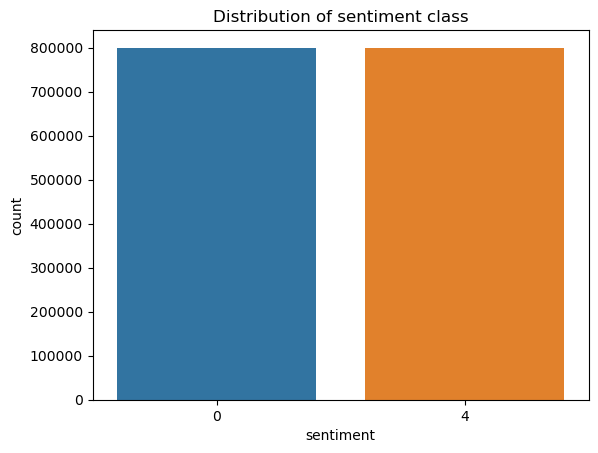

In [9]:
sns.countplot(data['sentiment'])
plt.title('Distribution of sentiment class')
plt.show()

In [10]:
data['label'] = np.where(data.sentiment ==0, 'negative', 'positive')
data['sentiment'] = data['sentiment'].replace(4,1)

In [11]:
data.head()

sentiment                                               text     label
0          0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  negative
1          0  is upset that he can't update his Facebook by ...  negative
2          0  @Kenichan I dived many times for the ball. Man...  negative
3          0    my whole body feels itchy and like its on fire   negative
4          0  @nationwideclass no, it's not behaving at all....  negative

# Test with 10000 samples per class

In [15]:
def sample_dataset(data, n_sample):
    
    new_data = data.groupby('sentiment', as_index=True).apply(lambda x: x.sample(n_sample)).reset_index(level=0, drop=True).sample(frac=1)
    
    return new_data

In [16]:
data_test = sample_dataset(data, 5000)

In [17]:
data_test.sentiment.value_counts()

1    5000
0    5000
Name: sentiment, dtype: int64

# Number of unique words in dataframe before text processing

In [18]:
def merge_list(serie):
    """ This function will concatenate each tokenized cells in one list and will remove ',' afterwards """
    
    i=0
    corpus = []
    while i<len(serie):
        corpus.append(serie.iloc[i])
        i+=1
    corpus = [j for i in corpus for j in i] # Operation [['a'], ['b']] = ['a','b']
    return corpus

In [19]:
tokenizer = RegexpTokenizer(r'\w+')
corpus = data_test.text.apply(lambda x: tokenizer.tokenize(x))

In [20]:
corpus = merge_list(corpus)

In [21]:
vocab_size = len(set(corpus))
vocab_size

21905

# Text_processing

Loading the spacy "en_core_web_sm" which is a small English pipeline trained on written web text that includes vocabulary, syntax and entities

In [22]:
nlp_spacy = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [23]:
def text_processing(serie):
    
    serie = serie.apply(lambda x: x.lower()) #lower all the letters of the tweet
    
    serie = serie.apply(remove_stopwords) #remove stopwords 
    
    serie = serie.apply(strip_non_alphanum) #remove non alpha numeric character
    
    serie = serie.apply(lambda x: strip_short(x, minsize=3)) #remove words below 2 characters
    
    serie = serie.apply(lambda x: " ".join([token.lemma_ for token in nlp_spacy(x)])) #lemmatization with spacy vocabulary
    
    return pd.DataFrame(serie)

In [24]:
data_test.text = text_processing(data_test.text)

In [25]:
data_test.head()

sentiment                                               text  \
1560538          1                   castingstone true maybe epic win   
465405           0                    mad nightmare skin crawl uuurgh   
1083903          1          want french fry fucking ketchup goodnight   
1133134          1  pdurham will double drunk clumsy ditzzy karaok...   
215912           0                          start study dot feel like   

            label  
1560538  positive  
465405   negative  
1083903  positive  
1133134  positive  
215912   negative

## Number of unique words in dataframe after text processing

In [26]:
tokenizer = RegexpTokenizer(r'\w+') #matches any word character
corpus = data_test.text.apply(lambda x: tokenizer.tokenize(x))

In [27]:
corpus = merge_list(corpus)

In [28]:
vocab_size_after = len(set(corpus))
vocab_size_after
print('Length unique words before text processing', vocab_size)
print('Length unique words after text processing', vocab_size_after)

Length unique words before text processing 21905
Length unique words after text processing 16425


# Train_test_split

Divide all the tweets selected into a train set et a test set with 80-20 ratio

In [29]:
X_train, X_test, y_train, y_test = train_test_split(data_test['text'], data_test['sentiment'], test_size=0.2, random_state=0)

# Tf-IDF

TF-IDF (term frequency-inverse document frequency) is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. If a word appears often in a particular document, but not in so many other documents, it is most likely that the word represents a particular meaning for that document and receives a larger count than before thanks to high Idf. On the other side, if a word appears in many documents, then its Idf is close to 1 and the logarithm turns 1 into 0 and decreases its effect

In [30]:
vectorizer = TfidfVectorizer().fit(X_train)
X_train_vectorized = vectorizer.transform(X_train)

In [31]:
X_test_vectorized = vectorizer.transform(X_test)

## Model

In [32]:
def model_evaluate(model):
    
    y_pred = model.predict(X_test_vectorized)
    
    print(classification_report(y_test, y_pred))
    
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative', 'Positive']
    group_names = ['True_neg', 'False Pos', 'False Neg', 'True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)
    
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [33]:
# parameters_log_reg = {"C":np.logspace(-3,3,7),
#                       "max_iter": [60+20*i for i in range(10)],
#                      "solver": ["newton-cg"]}

# log_reg = LogisticRegression()
# log_reg_cv = GridSearchCV(log_reg, parameters_log_reg, cv=5)
# log_reg_cv.fit(X_train_vectorized, y_train)

In [34]:
# print("Tuned hyperparameters :(best parameters) ",log_reg_cv.best_params_)
# print("Accuracy :",log_reg_cv.best_score_)

In [35]:
# best_params_lr = log_reg_cv.best_params_
# joblib.dump(best_params_lr, 'GSCV_modele_simple.pkl')

In [36]:
params = joblib.load('GSCV_modele_simple.pkl')

              precision    recall  f1-score   support

           0       0.73      0.71      0.72      1020
           1       0.71      0.73      0.72       980

    accuracy                           0.72      2000
   macro avg       0.72      0.72      0.72      2000
weighted avg       0.72      0.72      0.72      2000



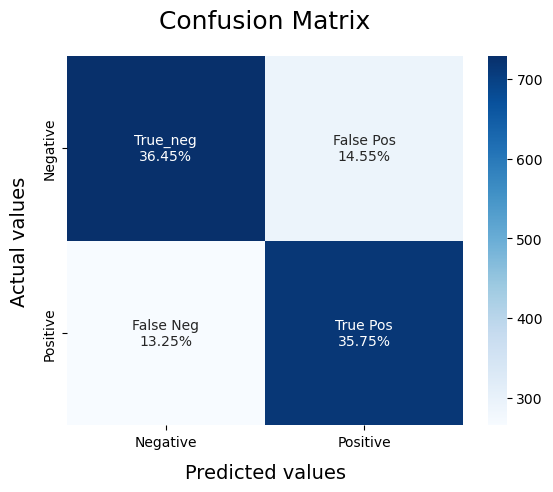

In [37]:
clf = LogisticRegression(**params)
clf.fit(X_train_vectorized, y_train)
model_evaluate(clf)

# Advanced Model

# KERAS EMBEDDING


# Distribution of comments based on number of tokens

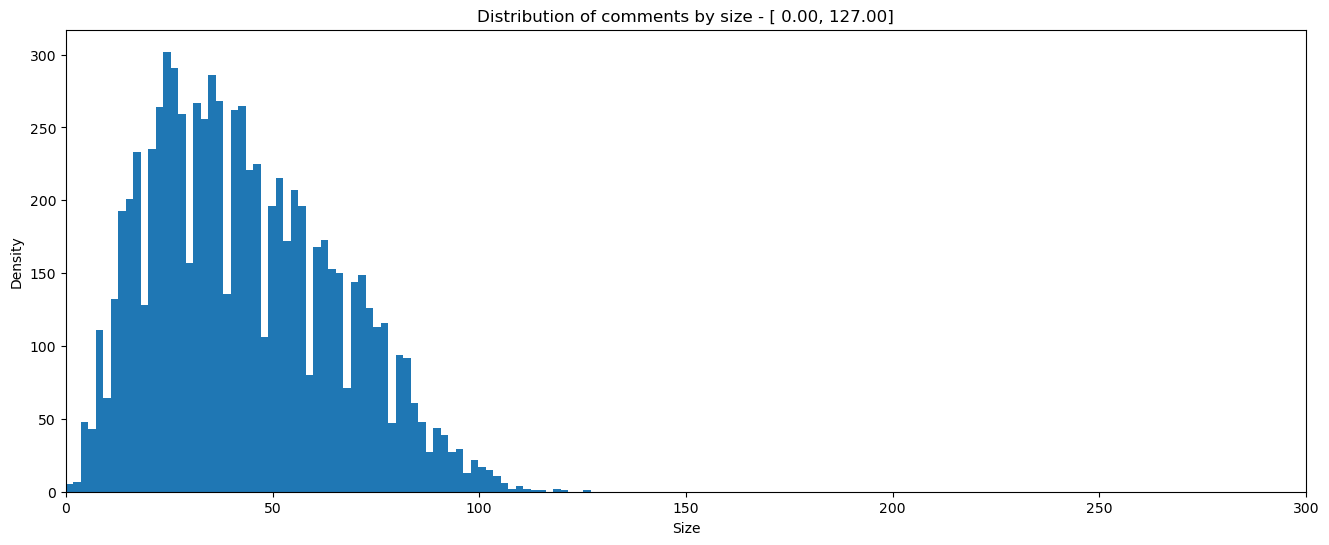

In [38]:
sizes=[len(i) for i in X_train]
plt.figure(figsize=(16,6))
plt.hist(sizes, bins=70)
plt.gca().set(title='Distribution of comments by size - [{:5.2f}, {:5.2f}]'.format(min(sizes),max(sizes)),
             xlabel='Size', ylabel='Density', xlim=[0,300])
plt.show()

# Word2VEC

Load the pre-trained word2vec model

In [39]:
w2v_model = word2vec.KeyedVectors.load_word2vec_format("C:\Mes Documents\Downloads\GoogleNews-vectors-negative300.bin.gz", binary=True)
dict_w2v = w2v_model.key_to_index

# Glove

Load the pre-trained glove model

In [40]:
def read_glove_vecs(glove_file):
    with open(glove_file, encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return word_to_vec_map, words_to_index

In [41]:
glove_model, dict_glove = read_glove_vecs(r"D:\Mes Documents\Bureau\glove.twitter.27B\glove.twitter.27B.200d.txt")

# Functions of preprocessing data and training LSTM Model

In [16]:
def sample_dataset(data, n_sample):
    
    new_data = data.groupby('sentiment', as_index=True).apply(lambda x: x.sample(n_sample)).reset_index(level=0, drop=True).sample(frac=1)
    
    return new_data

In [17]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [18]:
negative_stopwords = ['no', 'don', "don't", 'nor', 'not', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', 
                      "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', 
                      "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't",
                      'wouldn', "wouldn't", "can't", 't'
                     ]

In [19]:
stopwords = set(stopwords.words('english')) - set(negative_stopwords)

In [20]:
tokenizer = RegexpTokenizer(r'\w+')

### Text processing 
We define a function of text processing which will modify the tweets before running in the models

In [21]:
def text_processing(serie):
    
    tokenizer = RegexpTokenizer(r'\w+')
    serie = serie.apply(lambda x: x.lower()) #lower all the characters
    serie = serie.apply(lambda x: tokenizer.tokenize(x)) #tokenize the text
    serie = serie.apply(lambda x: [word for word in x if word not in stopwords]) #remove only non negative stopwords
    serie = serie.apply(lambda x: ' '.join([word for word in x]))
    
#     serie = serie.apply(remove_stopwords)
    
    serie = serie.apply(strip_non_alphanum) #remove non alpha numeric character
    serie = serie.apply(lambda x: strip_short(x, minsize=3)) #remove words below 2 characters
    
#     serie = serie.apply(lambda x: " ".join([token.lemma_ for token in nlp_spacy(x)])) 
    
    return pd.DataFrame(serie)

### Transform sequence function
This function will transform the tweets pre-processed into numbers that will define the tweet and can be compatible for the models

In [22]:
def transform_sequence(X_train, X_test, num_words, max_len):
    
    tokenizer = Tokenizer(num_words)
    tokenizer.fit_on_texts(X_train)
    
    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)
    
    vocab_size = len(tokenizer.word_index) + 1 #1 is added because of padding for index 0 by keras
    
    X_train = pad_sequences(X_train, value=0, padding='post', maxlen=max_len)
    X_test = pad_sequences(X_test, value=0, padding='post', maxlen=max_len)
    
    return X_train, X_test, vocab_size, tokenizer

## Creation of Embedding matricies

In [23]:
def create_embedding_from_pretrained(pretrained_model, dict_model, dim_vectors, vocab_size, num_words, tokenizer):
    
    weight_matrix = np.zeros((vocab_size, dim_vectors))

    for word, index  in tokenizer.word_index.items():
        if index < num_words: # "<" and not "<=" since index starts with zero 
            if word in dict_model:
                weight_matrix[index] = pretrained_model[word]
            else:
                weight_matrix[index] = np.zeros(dim_vectors)
                
    return weight_matrix

In [24]:
def create_embedding_layer(dim_vectors, vocab_size, max_len, weight_matrix=None):
    
    if weight_matrix is not None:
        embedding_layer = Embedding(input_dim=vocab_size,
                                   output_dim=dim_vectors,
                                   input_length=max_len,
                                   weights=[weight_matrix], trainable=False)
    else:
        embedding_layer = Embedding(input_dim=vocab_size,
                                   output_dim=dim_vectors,
                                   input_length=max_len)
    
    return embedding_layer

In [25]:
def get_model(max_len, embedding_layer):
    
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(max_len)))
    model.add(embedding_layer)
    
#     model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Bidirectional(LSTM(128, return_sequences=True)))
    model.add(keras.layers.Bidirectional(LSTM(64, return_sequences=True)))
    model.add(keras.layers.Bidirectional(LSTM(32, return_sequences=True)))
    model.add(keras.layers.Bidirectional(LSTM(16)))
#     model.add(Dropout(0.2))
    model.add(keras.layers.Dense(8, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer = Adam(learning_rate=0.001),
                 loss = 'binary_crossentropy',
                 metrics = ['accuracy'])
    
    print(model.summary())
    
    return model

In [26]:
def fit_model(model, batch_size, epochs):

    history = model.fit(X_train, y_train, epochs=epochs, verbose=1, batch_size=batch_size, validation_data=(X_test, y_test))
    
    return history

In [27]:
def graph_performances(history):
    
    
    metrics_df = pd.DataFrame(history.history)

    plt.figure(figsize=(15, 15))

    plt.subplot(2, 2, 1)
    plt.plot(metrics_df.index, metrics_df.loss)
    plt.plot(metrics_df.index, metrics_df.val_loss)
    plt.title('Reviews Sentiment Analysis Model Loss over Epochs')
    plt.yticks(np.arange(0, 1, step=0.2)) 
    plt.xlabel('Epochs')
    plt.ylabel('Binary Crossentropy')
    plt.legend(['Training Loss', 'Validation Loss'])

    plt.subplot(2, 2, 2)
    plt.plot(metrics_df.index, metrics_df.accuracy)
    plt.plot(metrics_df.index, metrics_df.val_accuracy)
    plt.title('Reviews Sentiment Analysis Model Accuracy over Epochs')
    plt.yticks(np.arange(0, 1, step=0.2)) 
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Training Accuracy', 'Validation'])
                
    return plt.show()

In [28]:
def classification(num_words, max_len, n_sample, dim_vectors=None, glove=None, w2v=None):
    
    new_data = sample_dataset(data, n_sample)
    new_data.text = text_processing(new_data.text)
    X_train, X_test, y_train, y_test = train_test_split(new_data['text'], new_data['sentiment'], stratify=new_data['sentiment'], test_size=0.2, random_state=0)
    X_train, X_test, vocab_size, tokenizer = transform_sequence(X_train, X_test, num_words, max_len)
    
    if glove is not None:
        dim_vectors = 200
        weight_matrix = create_embedding_from_pretrained(glove_model, dict_glove, dim_vectors, vocab_size, num_words, tokenizer)
        embedding_layer = create_embedding_layer(dim_vectors, vocab_size, max_len, weight_matrix=weight_matrix)
    
    elif w2v is not None:
        dim_vectors = 300
        weight_matrix = create_embedding_from_pretrained(w2v_model, dict_w2v, dim_vectors, vocab_size, num_words, tokenizer)
        embedding_layer = create_embedding_layer(dim_vectors, vocab_size, max_len, weight_matrix=weight_matrix)
    
    else:
        dim_vectors = dim_vectors
        embedding_layer = create_embedding_layer(vocab_size, dim_vectors, max_len)
        
    model = get_model(max_len, embedding_layer)
    
    return model, X_train, X_test, y_train, y_test, tokenizer

# Model with kerras embedding (no pre-trained embeddings)

In [74]:
model, X_train, X_test, y_train, y_test, tokenizer = classification(num_words=10000, max_len=40, n_sample=10000, dim_vectors=256)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 40, 25481)         6523136   
                                                                 
 bidirectional_28 (Bidirecti  (None, 40, 256)          26224640  
 onal)                                                           
                                                                 
 bidirectional_29 (Bidirecti  (None, 40, 128)          164352    
 onal)                                                           
                                                                 
 bidirectional_30 (Bidirecti  (None, 40, 64)           41216     
 onal)                                                           
                                                                 
 bidirectional_31 (Bidirecti  (None, 32)               10368     
 onal)                                                

In [75]:
start = perf_counter()

history = fit_model(model, batch_size=16, epochs=5)

end = perf_counter()
print(f"Time taken to execute code : {end-start}")

Epoch 1/5
1000/1000 [==============================] - 216s 207ms/step - loss: 0.6306 - accuracy: 0.6409 - val_loss: 0.5977 - val_accuracy: 0.6633
Epoch 2/5
1000/1000 [==============================] - 105s 105ms/step - loss: 0.5812 - accuracy: 0.6848 - val_loss: 0.5843 - val_accuracy: 0.6883
Epoch 3/5
1000/1000 [==============================] - 108s 108ms/step - loss: 0.5591 - accuracy: 0.6974 - val_loss: 0.5728 - val_accuracy: 0.6810
Epoch 4/5
1000/1000 [==============================] - 105s 105ms/step - loss: 0.5462 - accuracy: 0.7077 - val_loss: 0.5807 - val_accuracy: 0.6948
Epoch 5/5
1000/1000 [==============================] - 107s 107ms/step - loss: 0.5386 - accuracy: 0.7082 - val_loss: 0.5767 - val_accuracy: 0.6975
Time taken to execute code : 641.3189955000007


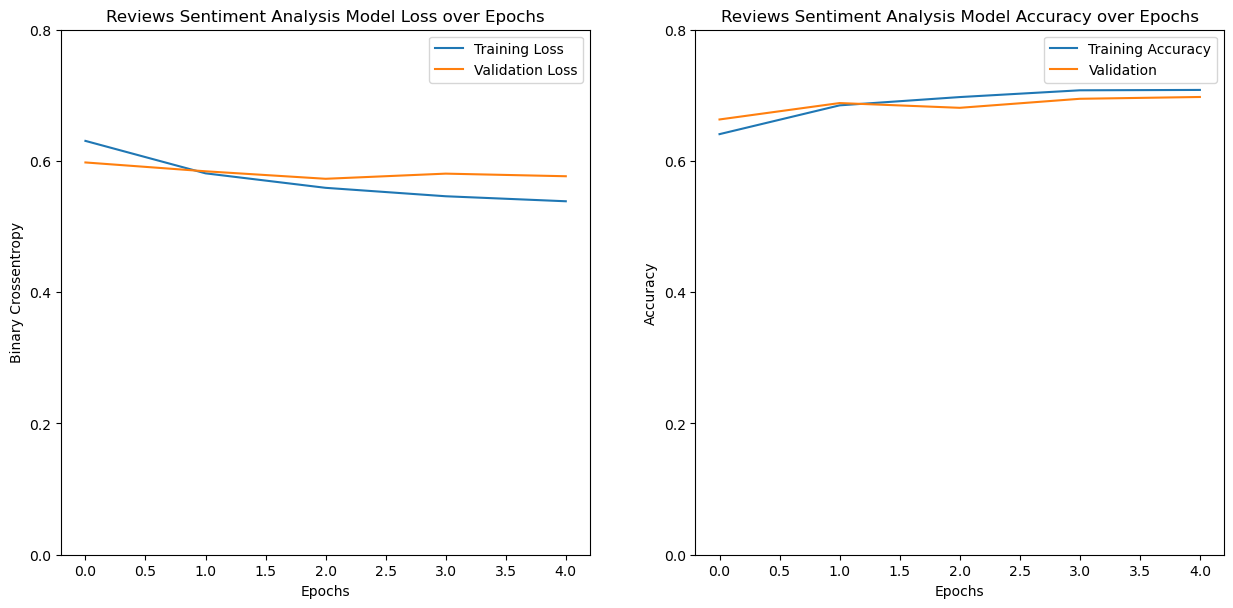

In [76]:
graph_performances(history)

# Model with Glove embedding

In [72]:
model, X_train, X_test, y_train, y_test, tokenizer_glove = classification(num_words=10000, max_len=40, n_sample=50000, glove=True)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 40, 200)           16134400  
                                                                 
 bidirectional_24 (Bidirecti  (None, 40, 256)          336896    
 onal)                                                           
                                                                 
 bidirectional_25 (Bidirecti  (None, 40, 128)          164352    
 onal)                                                           
                                                                 
 bidirectional_26 (Bidirecti  (None, 40, 64)           41216     
 onal)                                                           
                                                                 
 bidirectional_27 (Bidirecti  (None, 32)               10368     
 onal)                                                

In [73]:
start = perf_counter()

history = fit_model(model, batch_size=256, epochs=5)

end = perf_counter()
print(f"Time taken to execute code : {end-start}")

Epoch 1/5
313/313 [==============================] - 29s 61ms/step - loss: 0.5179 - accuracy: 0.7433 - val_loss: 0.4995 - val_accuracy: 0.7551
Epoch 2/5
313/313 [==============================] - 16s 51ms/step - loss: 0.4783 - accuracy: 0.7672 - val_loss: 0.4902 - val_accuracy: 0.7653
Epoch 3/5
313/313 [==============================] - 23s 74ms/step - loss: 0.4639 - accuracy: 0.7794 - val_loss: 0.4833 - val_accuracy: 0.7714
Epoch 4/5
313/313 [==============================] - 18s 59ms/step - loss: 0.4479 - accuracy: 0.7878 - val_loss: 0.4848 - val_accuracy: 0.7656
Epoch 5/5
313/313 [==============================] - 18s 58ms/step - loss: 0.4317 - accuracy: 0.7979 - val_loss: 0.4702 - val_accuracy: 0.7741
Time taken to execute code : 104.80283969999982


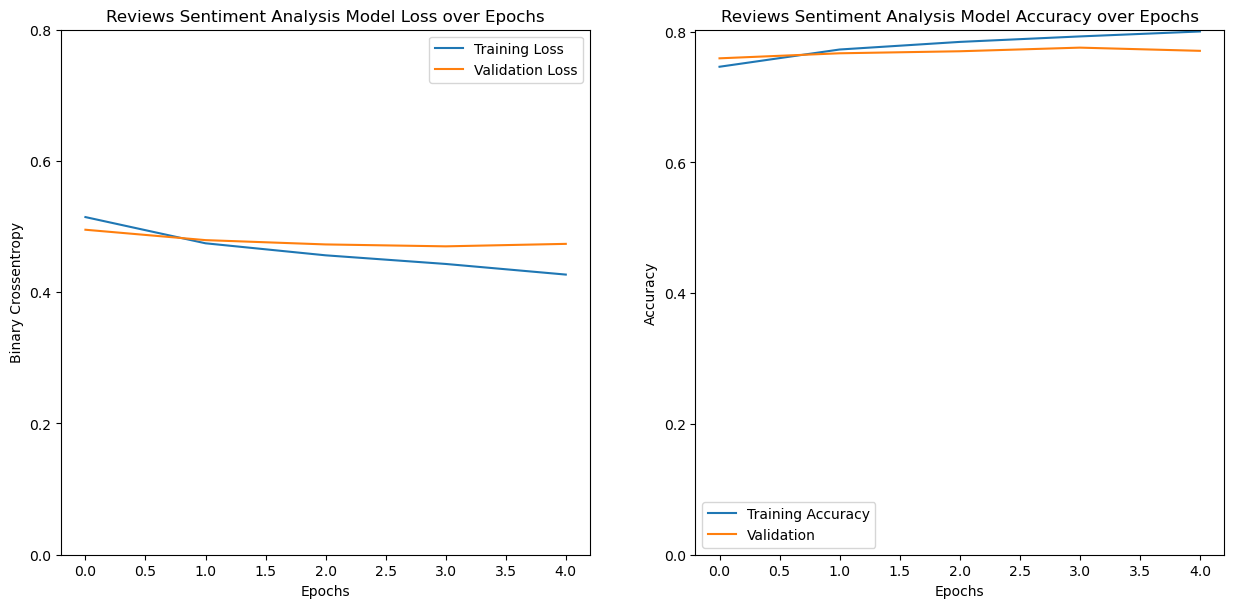

In [67]:
graph_performances(history)

# Model with Word2Vec embedding

In [77]:
model, X_train, X_test, y_train, y_test, tokenizer_w2v = classification(num_words=10000, max_len=40, n_sample=50000, w2v=True)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 40, 300)           24141300  
                                                                 
 bidirectional_32 (Bidirecti  (None, 40, 256)          439296    
 onal)                                                           
                                                                 
 bidirectional_33 (Bidirecti  (None, 40, 128)          164352    
 onal)                                                           
                                                                 
 bidirectional_34 (Bidirecti  (None, 40, 64)           41216     
 onal)                                                           
                                                                 
 bidirectional_35 (Bidirecti  (None, 32)               10368     
 onal)                                                

In [78]:
start = perf_counter()

history = fit_model(model, batch_size=256, epochs=5)

end = perf_counter()
print(f"Time taken to execute code : {end-start}")

Epoch 1/5
313/313 [==============================] - 35s 77ms/step - loss: 0.5387 - accuracy: 0.7293 - val_loss: 0.5142 - val_accuracy: 0.7483
Epoch 2/5
313/313 [==============================] - 22s 71ms/step - loss: 0.5031 - accuracy: 0.7552 - val_loss: 0.5038 - val_accuracy: 0.7578
Epoch 3/5
313/313 [==============================] - 20s 65ms/step - loss: 0.4846 - accuracy: 0.7687 - val_loss: 0.4917 - val_accuracy: 0.7612
Epoch 4/5
313/313 [==============================] - 21s 66ms/step - loss: 0.4695 - accuracy: 0.7768 - val_loss: 0.4807 - val_accuracy: 0.7715
Epoch 5/5
313/313 [==============================] - 21s 68ms/step - loss: 0.4559 - accuracy: 0.7836 - val_loss: 0.4737 - val_accuracy: 0.7756
Time taken to execute code : 119.65308600000026


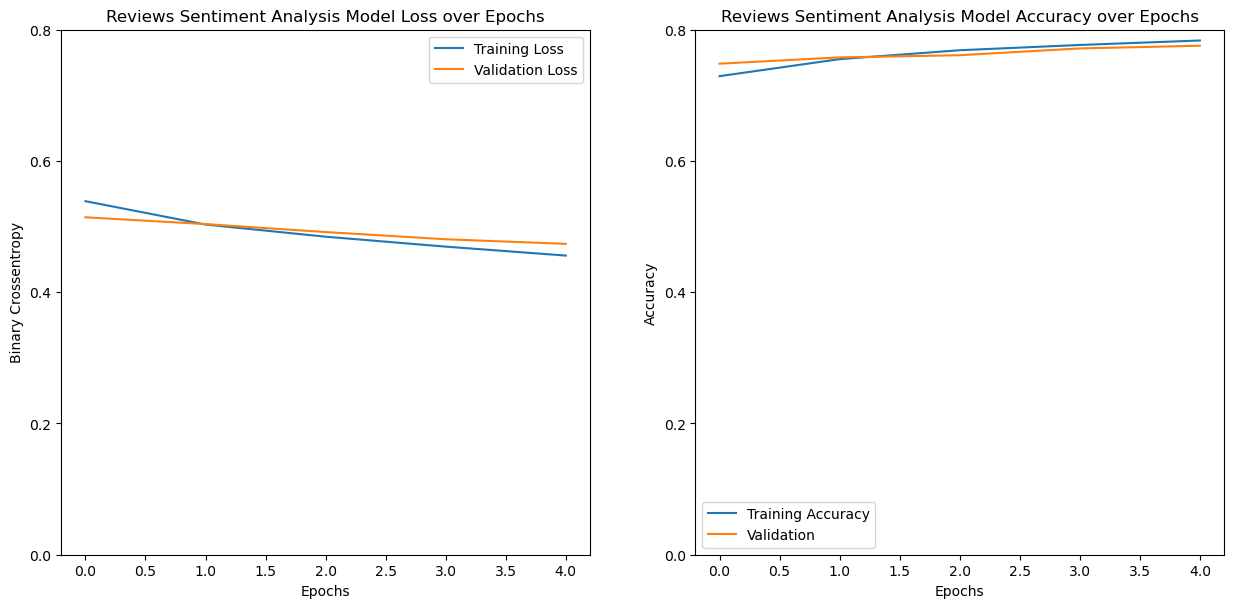

In [79]:
graph_performances(history)

# BERT

In [54]:
data

sentiment                                               text  \
0                0  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1                0  is upset that he can't update his Facebook by ...   
2                0  @Kenichan I dived many times for the ball. Man...   
3                0    my whole body feels itchy and like its on fire    
4                0  @nationwideclass no, it's not behaving at all....   
...            ...                                                ...   
1599995          1  Just woke up. Having no school is the best fee...   
1599996          1  TheWDB.com - Very cool to hear old Walt interv...   
1599997          1  Are you ready for your MoJo Makeover? Ask me f...   
1599998          1  Happy 38th Birthday to my boo of alll time!!! ...   
1599999          1  happy #charitytuesday @theNSPCC @SparksCharity...   

            label  
0        negative  
1        negative  
2        negative  
3        negative  
4        negative  
...           ...  
1599995  positive  
1599996  positive  
1599997  positive  
1599998  positive  
1599999  positive  

[1600000 rows x 3 columns]

In [76]:
data_test = sample_dataset(data, 5000)
data_test.text = text_processing(data_test.text)

In [77]:
data_test

sentiment                                               text  \
906160           1  follow aswel twitter follow lool www twitter c...   
498875           0             well not movie time went wrong theater   
546533           0               kaileebaylor haha sarahs game though   
151875           0                    cavaliers hurt feelings tonight   
1445443          1  ashleyltmsyf missing every day good day angel fan   
...            ...                                                ...   
244546           0                    tommylaad know fail things time   
1209968          1                   robkardashian heck winning thurs   
893327           1                                      joyofzen time   
199996           0                                               work   
861446           1  heidimontag stop listening new songs especiall...   

            label  
906160   positive  
498875   negative  
546533   negative  
151875   negative  
1445443  positive  
...           ...  
244546   negative  
1209968  positive  
893327   positive  
199996   negative  
861446   positive  

[10000 rows x 3 columns]

In [78]:
num_classes = len(data_test.sentiment.unique())

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=num_classes)

In [79]:
sentences = data_test['text']
labels = data_test['sentiment']
len(sentences), len(labels)

(10000, 10000)

In [80]:
input_ids=[]
attention_masks=[]

for sent in sentences:
    bert_inp=bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =64,pad_to_max_length = True,return_attention_mask = True, truncation=True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)

In [81]:
len(input_ids),len(attention_masks),len(labels)

(10000, 10000, 10000)

In [82]:
print('Preparing the pickle file.....')

pickle_inp_path='./data/bert_inp.pkl'
pickle_mask_path='./data/bert_mask.pkl'
pickle_label_path='./data/bert_label.pkl'

pickle.dump((input_ids),open(pickle_inp_path,'wb'))
pickle.dump((attention_masks),open(pickle_mask_path,'wb'))
pickle.dump((labels),open(pickle_label_path,'wb'))

print('Pickle files saved as ',pickle_inp_path,pickle_mask_path,pickle_label_path)

Preparing the pickle file.....
Pickle files saved as  ./data/bert_inp.pkl ./data/bert_mask.pkl ./data/bert_label.pkl


In [83]:
print('Loading the saved pickle files..')

input_ids=pickle.load(open(pickle_inp_path, 'rb'))
attention_masks=pickle.load(open(pickle_mask_path, 'rb'))
labels=pickle.load(open(pickle_label_path, 'rb'))

print('Input shape {} Attention mask shape {} Input label shape {}'.format(input_ids.shape,attention_masks.shape,labels.shape))

Loading the saved pickle files..
Input shape (10000, 64) Attention mask shape (10000, 64) Input label shape (10000,)


In [84]:
train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.2)

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))

Train inp shape (8000, 64) Val input shape (2000, 64)
Train label shape (8000,) Val label shape (2000,)
Train attention mask shape (8000, 64) Val attention mask shape (2000, 64)


In [85]:
log_dir='tensorboard_data/tb_bert'
model_save_path='./models/bert_model.h5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]

print('\nBert Model',bert_model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

Model: "tf_bert_for_sequence_classification_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_151 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________

Bert Model None


In [88]:
# start = perf_counter()

# history=bert_model.fit([train_inp,train_mask],train_label,batch_size=16,epochs=3,
#                        validation_data=([val_inp,val_mask],val_label),callbacks=callbacks)

# end = perf_counter()
# print(f"Time taken to execute code : {end-start}")

In [69]:
%load_ext tensorboard

In [79]:
from sklearn.metrics import confusion_matrix,f1_score,classification_report

In [87]:
model_save_path=r"D:\Users\Loulou\Dropbox\OpenClassrooms\P7\models\bert_model.h5"

trained_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)
trained_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])
trained_model.load_weights(model_save_path)

preds = trained_model.predict([val_inp,val_mask],batch_size=32)
pred_labels = np.argmax(preds.logits, axis=1)
f1 = f1_score(val_label,pred_labels)
print('F1 score',f1)
print('Classification Report')
print(classification_report(val_label,pred_labels))


63/63 [==============================] - 11s 121ms/step
F1 score 0.8018154311649016
Classification Report
              precision    recall  f1-score   support

           0       0.81      0.80      0.81      1015
           1       0.80      0.81      0.80       985

    accuracy                           0.80      2000
   macro avg       0.80      0.80      0.80      2000
weighted avg       0.80      0.80      0.80      2000

